# Test using actual GLM data

Like the test in Coordinate graph.ipynb, but adapted to use actual GLM data.

In [1]:
import glob

%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr
from glmtools.io.ccd import load_pixel_corner_lookup, quads_from_corner_lookup
from glmtools.io.glm import GLMDataset
from glmtools.grid.clipping import QuadMeshSubset, QuadMeshPolySlicer
from glmtools.grid.split_events import split_event_data, split_event_dataset_from_props, replicate_and_weight_split_event_dataset

In [2]:
lon_lut, lat_lut, corner_lut = load_pixel_corner_lookup('/data/LCFA-production/L1b/G16_corner_lut.pickle')

[-64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47
 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29
 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11
 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64]
[-60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43
 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25
 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7
  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11
  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56 

In [3]:
glm_files = glob.glob('/data/GOES16harvey/OR_GLM*.nc')
glm = GLMDataset(glm_files[0])
nadir_lon = glm.dataset.number_of_events.lon_field_of_view.data
print("Satellite is above {0} degrees longitude".format(nadir_lon))

Satellite is above -89.5 degrees longitude


In [4]:
# define a regular lat/lon grid. dlat of 0.01 is about 1 km resolution 
lonmin, lonmax = -105, -85
latmin, latmax = 18, 32
x = np.arange(lonmin, lonmax, 0.05)
y = np.arange(latmin, latmax, 0.05)
X,Y=np.meshgrid(x,y)
vals = np.random.rand(X.shape[0]-1, X.shape[1]-1)

# The expensive step
mesh = QuadMeshSubset(X, Y, n_neighbors=16)

Calculating polygons from mesh ...
    ... constructing search tree ... be patient ...
    ... done.


In [5]:
# We assume here that that the data are regularly gridded, 
# so that a single row or column are representative of the lons, lats
# along each dimension
# event_lons = glm.dataset.event_lon[:].data
# event_lats = glm.dataset.event_lat[:].data
# event_rads = glm.dataset.event_energy[:].data
# good = (event_lons > lonmin) & (event_lons < lonmax) & (event_lats > latmin) & (event_lats < latmax)
# subset_events = glm.dataset[{'number_of_events':good}]

glm_data = glm.subset_flashes(lon_range=(lonmin,lonmax),
                              lat_range=(latmin,latmax))

event_lons = glm_data.event_lon.data
event_lats = glm_data.event_lat.data
event_rads = glm_data.event_energy.data
event_ids = glm_data.event_id.data

# event_rads = np.log10(event_rads[good])
# rad_min, rad_max = event_rads.min(), event_rads.max()
# event_rads = event_rads[good]
# event_ids = glm.dataset.event_ids[good].data
rad_min, rad_max = 1e-16, .2e-13*5

event_polys = quads_from_corner_lookup(lon_lut[0,:], lat_lut[:,0], corner_lut, event_lons, event_lats, nadir_lon=nadir_lon)
print(event_polys.shape)

(1499, 4, 2)


In [7]:
# For adding up radiance values in any pixel, use the fractional area of the event


# def gen_split_events(chopped_polys, event_ids=None):
#     """
#     chopped_polys is a list of N polygons whose elements contain the sub-polys of each polygon.
#         It is the data structure created by QuadMeshPolySlicer.slice
#     event_ids are N corresponding event_ids
#     """
#     if event_ids is None: event_ids = range(len(chopped_polys))
    
#     for (subquads, frac_areas, (x_idxs, y_idxs)), total_area, evid in zip(chopped_polys, poly_areas, event_ids):
#         quad_fracs = slicer.quad_frac_from_poly_frac_area(
#                         frac_areas, total_area, x_idxs, y_idxs)

#         for subquad, frac_area, x_idx, y_idx, quad_area in zip(subquads, frac_areas, x_idxs, y_idxs, quad_fracs):
# #             print('-------')
# #             print('subquad', subquad)
# #             print('frac_area, quad_frac_area', frac_area, quad_area)
# #             print('evid, idx', evid, x_idx, y_idx)
#             yield (subquad, frac_area, quad_area, (x_idx, y_idx), evid)

# def split_event_dataset(split_polys, event_ids):
#     """
#     split_polys is a list of N polygons whose elements contain the sub-polys of each polygon.
#         It is the data structure created by QuadMeshPolySlicer.slice
#     event_ids are N corresponding event_ids
#     """

#     # fromiter would run faster if we could precalculate the count, though
#     # doing so would require iterating to sum some sizes, so it's not clear
#     # if there's much net benefit.
#     dtype = np.dtype([
# #         ('poly','f8',(4,2)), # polys could be any number of verts, so don't use.
#         ('poly_ctr', 'f8', (2,)),
#         ('event_frac_area', 'f8'),
#         ('mesh_frac_area', 'f8'),
#         ('mesh_idx', 'i8', (2,)),
# #         ('mesh_y_idx', 'i8'),
#         ('event_id', 'u8')
#     ])
    
#     parts_of_split_polys = [p for p in gen_split_events(split_polys, event_ids)]
    
#     # Each element here will be an (n_verts, 2) array of polygon vertex locations.
#     sub_polys = [np.asarray(sp[0],dtype='f8') for sp in parts_of_split_polys]

#     # These are frac_area, quad_area, (x_idx, y_idx), evid - i.e., 
#     # the parts with the same length that can be turned into an array.
#     split_event_property_iter = (sp[1:] for sp in parts_of_split_polys)
    
#     n_sub_polys = len(sub_polys)
    
# #     for sp, (frac_area, quad_area, idxs, evid) in zip(sub_polys, split_event_property_iter):
# #         sp.mean(axis=0)
    
#     split_event_iter = ((sp.mean(axis=0), frac_area, quad_area, idxs, evid)
#                         for (sp, (frac_area, quad_area, idxs, evid)) in 
#                         zip(sub_polys, split_event_property_iter))
    
#     d = np.fromiter(split_event_iter, dtype=dtype, count=n_sub_polys)

#     return sub_polys, d
    

def gen_polys(chopped_polys):
    # After getting the flash_data in io.read_flashes, pass the glm dataset 
    # to a function that does the polygon buisness. Will also need the grid spec.
    # Then do below.

    # dimension['number_of_split_events']  = n_chopped_polys # resulting from the iterator
    # Along that dimension need varaibles split_event_lat, split_event_lon, split_event_flash_id, 
    # split_event_parent_event_id, split_event_time_offset, split_event_energy
    
    # subquad_ctrs = subquad.mean(axis=) # along dimension with size 4.
    # split_event_lon = subquad_ctrs[:,:,0],
    # split_event_lat = subquad_ctrs[:,:,1],
    # split_event_parent_event_id = event_id (from iterator)
    # split_event_parent_group_id = event_parent_group_id (from iterator)
    # split_event_parent_flash_id = event_parent_flash_id (from iterator)
    # split_event_time_offset = area*event_rads (from iterator)
    # split_event_energy = event_time_offset (from iterator)
    
    # Also need to calculate split_event_count
    
    # The above is a replication operation, so maybe we could use the traversal class to create
    # the necessary variables after replicating the IDs only. But I think if we replicate the IDs,
    # which are part of the index, we can use the event_id column (which contains the replicated ids)
    # replicate any variable by indexing with event_id.
    
    # 
    
    # This loops over the original events
    # Generate a bunch of new events from the original events by weighting the original events
    # by their areas. To link back to the original data, retain the event_id. A
    # event_id, lon, lat, 
#         event_dtype=[('flash_id', '<i4'), 
#                  ('alt', '<f4'), 
# #                  ('charge', 'i1'), ('chi2', '<f4'), ('mask', 'S4'), ('stations', 'u1'),
#                  ('lat', '<f4'), ('lon', '<f4'), ('time', '<f8'),
#                  ('power', '<f4'), ]

    
    for (subquads, areas, (x_idxs, y_idxs)), total_area, val in zip(chopped_polys, poly_areas, poly_vals):
        quad_fracs = slicer.quad_frac_from_poly_frac_area(
                        areas, total_area, x_idxs, y_idxs)

        for subquad, area, x_idx, y_idx, quad_area in zip(subquads, areas, x_idxs, y_idxs, quad_fracs):
#             print('-------')
#             print('subquad', subquad)
#             print('frac_area, quad_frac_area', area, quad_area)
#             print('idx', x_idx, y_idx)
            yield (subquad, area, (x_idx, y_idx), val*area)
        
# good_polys = [p for p in gen_polys(chopped_polys)]

# good_polys = get_glm_split_events(chopped_polys, event_ids)



    
# #     d = {'coords': {'t': {'dims': 't', 'data': t,
# #                       'attrs': {'units':'s'}}},
# #      'attrs': {'title': 'air temperature'},
# #      'dims': 't',
# #      'data_vars': {'a': {'dims': 't', 'data': x, },
# #                    'b': {'dims': 't', 'data': y}}}

    
#     data = xr.DataArray(np.random.randn(2, 3), coords={'x': ['a', 'b']}, dims=('x', 'y'))


# d = 'coords':{'number_of_split_events': {'dims':'number_of_split_events'}}




    

# def split_event_dataset_from_props(props):
#     """ props is the numpy array with named dtype returned by split_event_dataset """
    
#     dims = ('number_of_split_events',)
#     d ={
#         'split_event_lon': {'dims':dims, 'data':split_event_properties['poly_ctr'][:,0]},
#         'split_event_lat': {'dims':dims, 'data':split_event_properties['poly_ctr'][:,1]},
#         'split_event_mesh_area_fraction': {'dims':dims, 'data':split_event_properties['mesh_frac_area']},
#         'split_event_area_fraction': {'dims':dims, 'data':split_event_properties['event_frac_area']},
#         'split_event_mesh_x_idx': {'dims':dims, 'data':split_event_properties['mesh_idx'][:,0]},
#         'split_event_mesh_y_idx': {'dims':dims, 'data':split_event_properties['mesh_idx'][:,1]},
#         'split_event_parent_event_id': {'dims':dims, 'data':split_event_properties['event_id']},
# #         'split_event_parent_group_id': {'dims':dims, 'data':}  = event_parent_group_id (from replication)
# #         'split_event_parent_flash_id': {'dims':dims, 'data':}  = event_parent_flash_id (from replication)
# #         'split_event_time_offset': {'dims':dims, 'data':}  = (from replication)
# #         'split_event_energy': {'dims':dims, 'data':}  = (from replication)
#     }
#     return xr.Dataset.from_dict(d)


# def replicate_and_weight_split_event_dataset(glm, split_event_dataset,
#                                              names=['event_energy', 'event_time_offset',
#                                                     'event_parent_flash_id', 'event_parent_group_id'],
#                                              weights={'event_energy':'split_event_area_fraction'}
#                                             ):
    
#     replicated_event_ids = split_event_dataset.split_event_parent_event_id

#     # replicate the event radiances using the replicated event_ids. 
#     # This chunk is stolen from the traversal.replicate_parent_id class
#     # and should be moved back there after it's generalized 
#     grouper = glm.entity_groups['event_id']
#     e_idx = [grouper.groups[eid] for eid in replicated_event_ids.data]
#     e_idx_flat = np.asarray(e_idx).flatten()
    
#     for name in names:
#         new_name = 'split_' + name
#         new_var = getattr(glm.dataset, name)[e_idx_flat]
#         if name in weights:
#             weight_var = getattr(split_event_dataset, weights[name])
#             # dimension names won't match, but lengths should.
#             new_var *= weight_var.data
#         # add variable to the dataset
#         split_event_dataset[new_name] = new_var 
        
#     return split_event_dataset


slicer = QuadMeshPolySlicer(mesh)

chopped_polys, poly_areas = slicer.slice(event_polys)
# print(chopped_polys)

# poly_vals = event_rads


split_event_polys, split_event_properties = split_event_data(chopped_polys, poly_areas, slicer, event_ids=event_ids)

split_event_dataset = split_event_dataset_from_props(split_event_properties)
# print(split_event_dataset.split_event_parent_event_id)

split_event_dataset = replicate_and_weight_split_event_dataset(glm, split_event_dataset)
print(split_event_dataset.split_event_parent_event_id)




# should be equal
# isequal = glm.dataset.event_id[e_idx_flat].data == replicated_event_ids.data
# print('checking for equality:', isequal.all())
# print(glm.dataset.event_id[e_idx_flat])
# print(split_event_dataset)






Polygon only 57.54682436719273 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 57.54682436719273 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 57.957655271204544 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 97.62691642336708 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 84.09202549452361 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 47.633961480308486 percent covered b

<IPython.core.display.Javascript object>


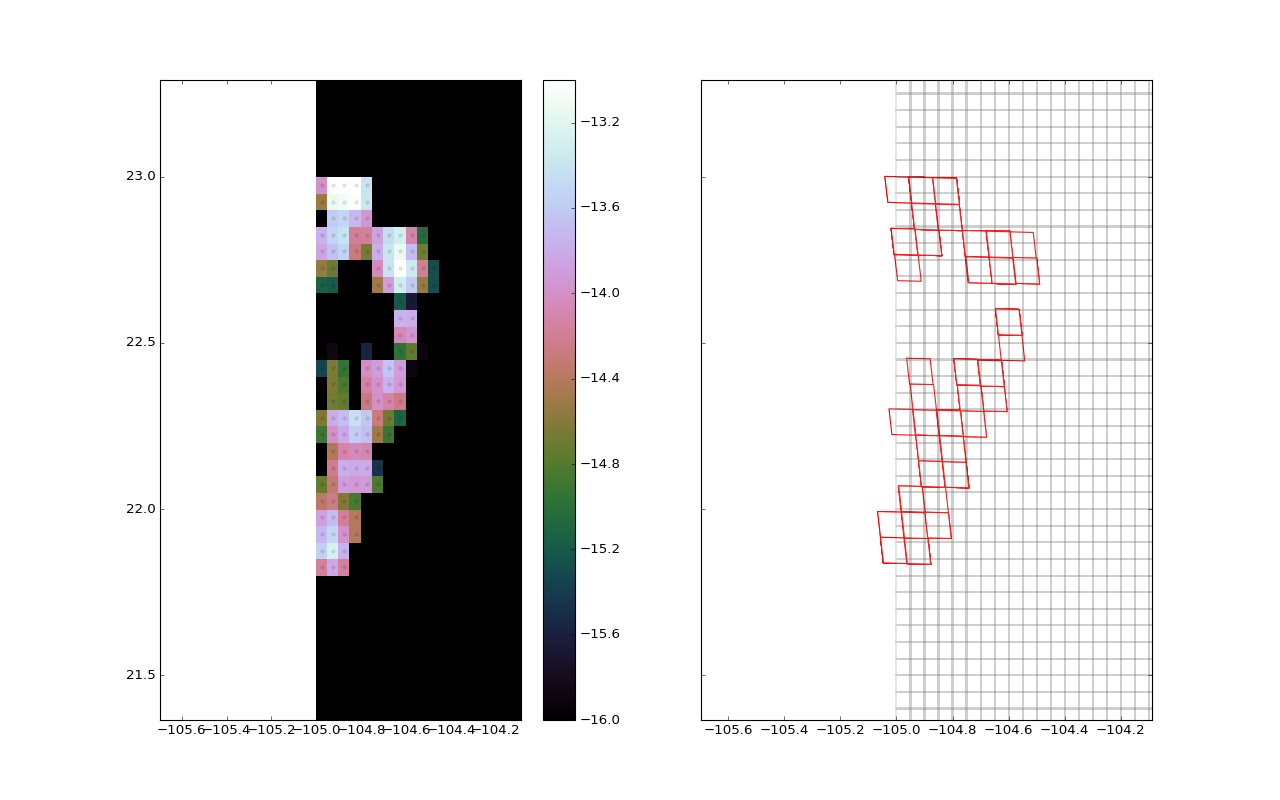

In [117]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig, axs = plt.subplots(1,2, figsize=(16,10), sharex=True, sharey=True)
ax = axs[0]
ax1 = axs[1]

vmin, vmax = rad_min, rad_max


vals *= 0
# Loop over each sub-quad, using the ctrs 
for p, area, (x_idx, y_idx), val in good_polys:
    vals[x_idx, y_idx] += val

# Chopped polys
pm = ax.pcolormesh(X, Y, np.log10(vals), alpha=1.0, edgecolor='none', cmap='cubehelix', vmin=np.log10(vmin), vmax=np.log10(vmax))
ax.plot(mesh.X_ctr, mesh.Y_ctr, '.k', alpha=0.1)
patches = [Polygon(p, True) for p, area, ctrs, val in good_polys]
patch_coll = PatchCollection(patches, edgecolors='red', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
patch_vals = np.asarray([val for p, area, ctrs, val in good_polys])
patch_coll.set_array(patch_vals)
# ax.add_collection(patch_coll)
plt.colorbar(pm, ax=ax)

# Original polys
patches = [Polygon(p, True) for p in event_polys]
patch_coll = PatchCollection(patches, edgecolors='red', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
# patch_coll.set_array(np.fromiter((0 for p in event_polys), dtype=float))
patch_coll.set_array(event_rads)
ax1.add_collection(patch_coll)
pm1 = ax1.pcolormesh(X,Y, vals*0, edgecolor='k', alpha=0.1, norm=pm.norm, cmap=pm.cmap)


# x0, x1, y0, y1 = X.min(), X.max(), Y.min(), Y.max()

# ax.axis((.4,1.5,10,16))
# ax.axis((-93.5,-93,29,30))

In [104]:
10**-14.5

3.1622776601683794e-15

In [160]:
glm.dataset.event_id[[0,2,2,5]]

<xarray.DataArray 'event_id' (number_of_events: 4)>
array([2172469089, 2172469092, 2172469092, 2172469095])
Coordinates:
  * number_of_events       (number_of_events) MultiIndex
  - event_parent_group_id  (number_of_events) int64 873477230 873477230 ...
  - event_id               (number_of_events) int64 2172469089 2172469092 ...
  - event_time_offset      (number_of_events) datetime64[ns] 2017-08-24T23:59:59.949000 ...
  - event_lat              (number_of_events) float64 4.435 4.36 4.36 4.36
  - event_lon              (number_of_events) float64 -61.1 -61.02 -61.02 -60.95
    product_time           datetime64[ns] 2017-08-25
    lightning_wavelength   float64 777.4
    group_time_threshold   float64 0.0
    flash_time_threshold   float64 3.33
    lat_field_of_view      float64 0.0
    lon_field_of_view      float64 -89.5

In [159]:
glm.dataset[{'number_of_events':[0,2,2,5]}].event_id

<xarray.DataArray 'event_id' (number_of_events: 4)>
array([2172469089, 2172469092, 2172469092, 2172469095])
Coordinates:
  * number_of_events       (number_of_events) MultiIndex
  - event_parent_group_id  (number_of_events) int64 873477230 873477230 ...
  - event_id               (number_of_events) int64 2172469089 2172469092 ...
  - event_time_offset      (number_of_events) datetime64[ns] 2017-08-24T23:59:59.949000 ...
  - event_lat              (number_of_events) float64 4.435 4.36 4.36 4.36
  - event_lon              (number_of_events) float64 -61.1 -61.02 -61.02 -60.95
    product_time           datetime64[ns] 2017-08-25
    lightning_wavelength   float64 777.4
    group_time_threshold   float64 0.0
    flash_time_threshold   float64 3.33
    lat_field_of_view      float64 0.0
    lon_field_of_view      float64 -89.5

In [156]:
glm.dataset.coords

Coordinates:
  * number_of_flashes                 (number_of_flashes) MultiIndex
  - flash_id                          (number_of_flashes) int64 56221 56279 ...
  - flash_time_offset_of_first_event  (number_of_flashes) datetime64[ns] 2017-08-24T23:59:59.898000 ...
  - flash_time_offset_of_last_event   (number_of_flashes) datetime64[ns] 2017-08-25T00:00:00.056000 ...
  - flash_lat                         (number_of_flashes) float64 4.417 ...
  - flash_lon                         (number_of_flashes) float64 -60.99 ...
  * number_of_groups                  (number_of_groups) MultiIndex
  - group_parent_flash_id             (number_of_groups) int64 56221 56221 ...
  - group_id                          (number_of_groups) int64 873477230 ...
  - group_time_offset                 (number_of_groups) datetime64[ns] 2017-08-24T23:59:59.898000 ...
  - group_lat                         (number_of_groups) float64 4.436 4.36 ...
  - group_lon                         (number_of_groups) float64 -61.0

In [164]:
grouper = glm.entity_groups['event_id']
e_idx = [grouper.groups[eid] for eid in [2172469089, 2172469092, 2172469092, 2172469095]]
e_idx_flat = np.asarray(e_idx).flatten()
print(glm.dataset.event_energy[e_idx_flat])
print(glm.dataset.event_id[e_idx_flat])

<xarray.DataArray 'event_energy' (number_of_events: 4)>
array([  4.525970e-15,   6.051940e-15,   6.051940e-15,   4.525970e-15])
Coordinates:
  * number_of_events       (number_of_events) MultiIndex
  - event_parent_group_id  (number_of_events) int64 873477230 873477230 ...
  - event_id               (number_of_events) int64 2172469089 2172469092 ...
  - event_time_offset      (number_of_events) datetime64[ns] 2017-08-24T23:59:59.949000 ...
  - event_lat              (number_of_events) float64 4.435 4.36 4.36 4.36
  - event_lon              (number_of_events) float64 -61.1 -61.02 -61.02 -60.95
    product_time           datetime64[ns] 2017-08-25
    lightning_wavelength   float64 777.4
    group_time_threshold   float64 0.0
    flash_time_threshold   float64 3.33
    lat_field_of_view      float64 0.0
    lon_field_of_view      float64 -89.5
Attributes:
    long_name:      GLM L2+ Lightning Detection: event radiant energy
    standard_name:  lightning_radiant_energy
    units:          

In [172]:
for k,v in {'event_energy':'split_event_area_fraction'}.items():
    print(k, v)

event_energy split_event_area_fraction


In [173]:
'event_energy' in {'event_energy':'split_event_area_fraction'}

True